In [7]:
import os
import pandas as pd
import tensorflow as tf
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Bidirectional, Conv1D, GlobalMaxPooling1D, Concatenate, AdditiveAttention
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import AdditiveAttention
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from utils import eval, eval_training, get_train_test_data, save_for_evaluation, process_train_test_data
import re
import numpy as np
import spacy
from gensim.models import Word2Vec
from transformers import BertTokenizer, TFBertModel


os.environ['TF_NUM_INTEROP_THREADS'] = '10'
os.environ['TF_NUM_INTRAOP_THREADS'] = '10'

# Configure TensorFlow session for multi-threading
tf.config.threading.set_inter_op_parallelism_threads(10)
tf.config.threading.set_intra_op_parallelism_threads(10)
# Ensure TensorFlow is using the Metal backend
gpu = len (tf.config.list_physical_devices ('GPU'))>0
print ("GPU is", "available" if gpu else "NOT AVAILABLE")

GPU is available


# Data preparation

label
other-minor                 9805
meniskus-urgent             9312
cruciate-ligament-urgent    2388
meniskus-minor              1664
cruciate-ligament-minor      355
Name: count, dtype: int64


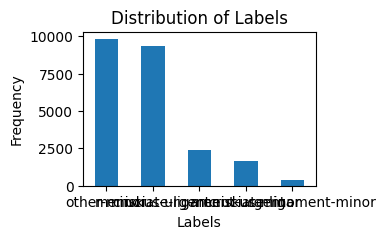

In [8]:
data_label = "data"
predict_label = "label"
balanced = False
labels = None
class_weights = False
sample_weights = False
df_train = pd.read_csv('../data/data_train.csv')
df_valid = pd.read_csv('../data/data_valid.csv')
df_test = pd.read_csv('../data/data_test.csv')

train_padded, valid_padded, test_padded, train_labels, valid_labels, test_labels, label_encoder, num_classes, max_length, word_index, class_weights, sample_weights = process_train_test_data(df_train, df_valid, df_test, data_label, predict_label, lables=labels, class_weights=class_weights, sample_weights=sample_weights)

# Model parameters

In [9]:
model_name = "attention"

In [10]:
from utils import get_standard_parameters

optimizer, loss, metrics, early_stopping_callback, embedding_dim, lstm_units, epochs, batch_size = get_standard_parameters()

# Model definition and training

In [14]:
from tensorflow.keras.layers import Attention, Flatten

# Define the input layer
input_text = Input(shape=(max_length,), dtype='int32', name='text_input')

# Embedding layer
embedding = Embedding(input_dim=len(word_index), output_dim=embedding_dim)(input_text)

# Two LSTM layers
x = Bidirectional(LSTM(units=lstm_units, return_sequences=True))(embedding)
x = Dropout(0.5)(x)
x = Bidirectional(LSTM(units=lstm_units, return_sequences=True))(x)

# Applying Attention Mechanism
query, value = x, x
attention = Attention()([query, value])
flattened_output = Flatten()(attention)

# Output layer
output = Dense(num_classes, activation='softmax')(flattened_output)
# Define the model
model = Model(inputs=input_text, outputs=output)

# Compile the model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [15]:
history = model.fit(train_padded, train_labels, epochs=epochs, batch_size=batch_size,
                    validation_data=(valid_padded, valid_labels), callbacks=[early_stopping_callback])

Epoch 1/15


2024-07-25 18:14:30.426285: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


736/736 ━━━━━━━━━━━━━━━━━━━━ 149s 198ms/step - accuracy: 0.4355 - auc: 0.7988 - f1_score: 0.2332 - loss: 1.2099 - val_accuracy: 0.5649 - val_auc: 0.8606 - val_f1_score: 0.3516 - val_loss: 1.0455
Epoch 2/15
736/736 ━━━━━━━━━━━━━━━━━━━━ 144s 196ms/step - accuracy: 0.6213 - auc: 0.8881 - f1_score: 0.4073 - loss: 0.9362 - val_accuracy: 0.5976 - val_auc: 0.8805 - val_f1_score: 0.3719 - val_loss: 0.9700
Epoch 3/15
736/736 ━━━━━━━━━━━━━━━━━━━━ 143s 195ms/step - accuracy: 0.7070 - auc: 0.9307 - f1_score: 0.5769 - loss: 0.7347 - val_accuracy: 0.6241 - val_auc: 0.8878 - val_f1_score: 0.4822 - val_loss: 0.9848
Epoch 4/15
736/736 ━━━━━━━━━━━━━━━━━━━━ 136s 185ms/step - accuracy: 0.7699 - auc: 0.9573 - f1_score: 0.7244 - loss: 0.5741 - val_accuracy: 0.6530 - val_auc: 0.8950 - val_f1_score: 0.5343 - val_loss: 1.0440
Epoch 5/15
736/736 ━━━━━━━━━━━━━━━━━━━━ 139s 189ms/step - accuracy: 0.8167 - auc: 0.9729 - f1_score: 0.7909 - loss: 0.4569 - val_accuracy: 0.6750 - val_auc: 0.8992 - val_f1_score: 0.5782 

In [16]:
save_for_evaluation(model, history, model_name, test_padded, test_labels, label_encoder)

Model saved to models/attention/attention.h5
Data saved


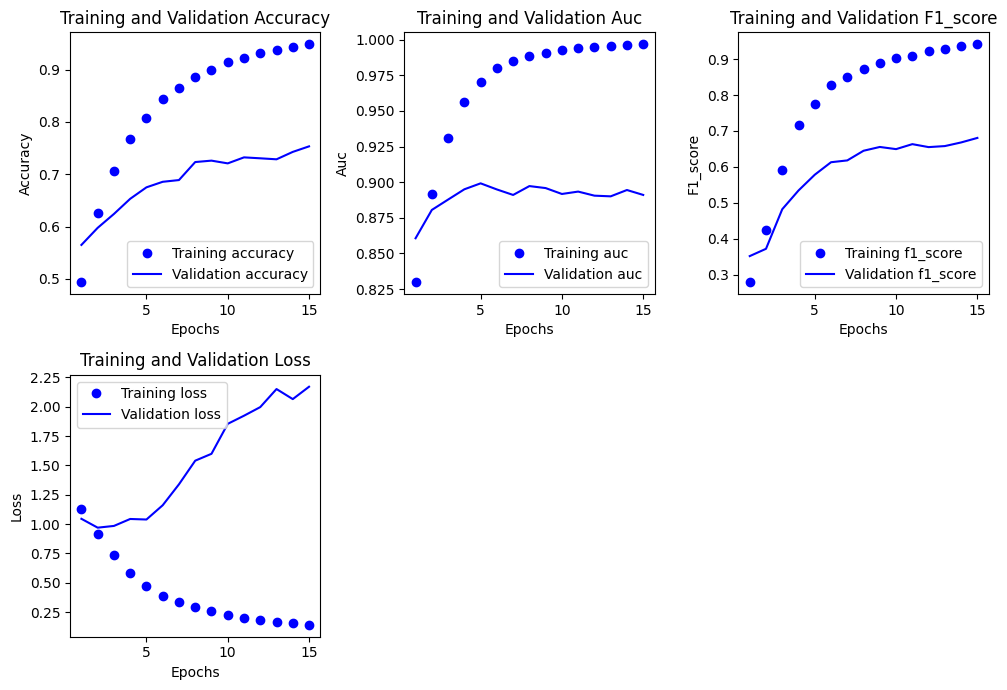

In [17]:
eval_training(history, metrics)

246/246 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step


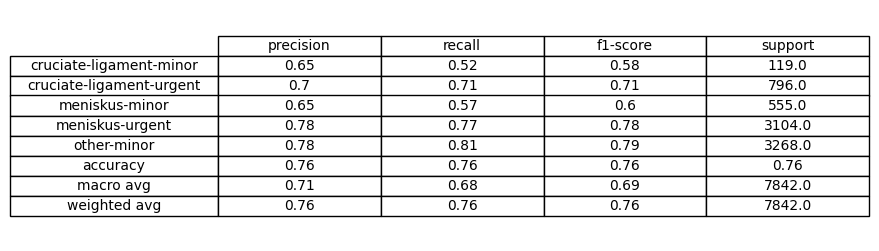

In [18]:
eval(model, test_padded, test_labels, label_encoder)